In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow_addons as tfa
import glob

In [2]:
size = 224

In [3]:
def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [4]:
def channeling(img1, img2, img3):
    return np.stack([img1, img2, img3], axis=-1)

In [5]:
def load_image(path):
    data_path = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_images/'
    UID = path.split('/')[-1][:-7]+"/"
    data = dcm.dcmread(data_path+UID+os.listdir(data_path+UID)[0])
    _, _, intercept, slope = get_windowing(data)
    img = nib.load(path)
    img = img.get_fdata()
    return img, intercept, slope

In [6]:
# def extract(path):
   
#     final_ct = load_image(path+"/"+"1.dcm").reshape(1,size,size)
#     for image in range(1, len(os.listdir(path))):
#         img = load_image(path+"/"+str(image)+".dcm").reshape(1,size,size)
#         final_ct = np.append(final_ct, img, axis=0)
        
#     resized_final_ct = cv2.resize(final_ct[:,:,0], (size,size)).reshape(1,size,size)
#     for i in range(1,final_ct.shape[1]):
#         resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,:,i], (size,size)).reshape(1,size,size), axis=0)
  

#     return window(resized_final_ct)

In [7]:
bb_df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train.csv")


In [8]:
bb_df[['x', 'y', 'width', 'height']] = (bb_df[['x', 'y', 'width', 'height']]//2).astype(int)

In [9]:
not_patients = df[df['patient_overall']==0]['StudyInstanceUID']

In [10]:
patients = bb_df['StudyInstanceUID'].unique()

In [11]:
not_patients

3       1.2.826.0.1.3680043.12351
7       1.2.826.0.1.3680043.17364
8         1.2.826.0.1.3680043.849
12      1.2.826.0.1.3680043.24946
13       1.2.826.0.1.3680043.9290
                  ...            
2011    1.2.826.0.1.3680043.32263
2012     1.2.826.0.1.3680043.6398
2013    1.2.826.0.1.3680043.31621
2016    1.2.826.0.1.3680043.14341
2017    1.2.826.0.1.3680043.12053
Name: StudyInstanceUID, Length: 1058, dtype: object

In [12]:
def get_slice_list(uid):
   final_list = set({})
   for i in range(bb_df[bb_df['StudyInstanceUID'] == uid].shape[0]):
      minn = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["x"]
      width = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["width"]
      slice_list = list(range(minn,minn+width+1))
      final_list.update(slice_list)
   return list(final_list)

In [194]:
# path = '../storage/'
# for patient in tqdm(patients):
#     try:
#         slices = get_slice_list(patient)
#         ct,intercept,slope = load_image(path+patient+'.nii.gz')
#         for slice in slices:
#             img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
#             img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
#             img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
#             img = channeling(img1,img2,img3)
#             ni_img = nib.Nifti1Image(img, affine=np.eye(4))
#             nib.save(ni_img, '../sagittal_positive_slices/'+patient+"."+str(slice) +".nii.gz")

#     except:
#         continue

100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


In [195]:
path = '../storage/'
for patient in tqdm(not_patients):
    try:
        slices = list(range(80, 170,3))
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        for slice in slices:
            img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
            img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
            img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=np.eye(4))
            nib.save(ni_img, '../sagittal_negative_slices/'+patient+"."+str(slice) +".nii.gz")

    except:
        continue

100%|██████████| 1058/1058 [13:43<00:00,  1.28it/s]


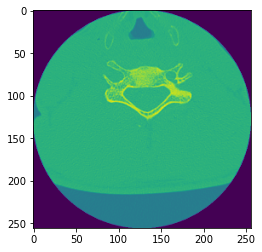

In [194]:
slice = nib.load('../storage/1.2.826.0.1.3680043.142.nii.gz')
slice = slice.get_fdata()
plt.imshow(slice[150])

In [198]:

positive_list = glob.glob('../sagittal_positive_slices/*')
negative_list = glob.glob('../sagittal_negative_slices/*')
positive_list.extend(negative_list)
number_samples = len(positive_list)
n_80 = int((number_samples*4)//5)
final_random_list = np.random.choice(positive_list,size = number_samples, replace=False)

In [199]:
def data_gen():
    for image in final_random_list[:n_80]:
        if image.split("_")[1] == "positive":
            img = nib.load(image)
            img = img.get_fdata()
            yield cv2.resize(img, (256, 256)) , 1, 2
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield cv2.resize(img, (256, 256)) , 0, 1
def test_gen():
    for image in final_random_list[n_80:]:
        if image.split("_")[1] == "positive":
            img = nib.load(image)
            img = img.get_fdata()
            yield cv2.resize(img, (256, 256)), 1, 2
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield cv2.resize(img, (256, 256)) , 0, 1

In [200]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     (tf.float32, tf.int8, tf.int8),
    (tf.TensorShape([256,256,3]), 
     tf.TensorShape([]),
    tf.TensorShape([]))
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     (tf.float32, tf.int8, tf.int8),
    (tf.TensorShape([256,256,3]), 
     tf.TensorShape([]),
    tf.TensorShape([]))
)

In [201]:
augment = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.3),
  keras.layers.GaussianNoise(0.1),
  keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=5),
  keras.layers.RandomContrast(0.1, seed=2),
  keras.layers.RandomZoom(
    (-0.2, 0.2),
    (-0.2, 0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=3)
])

In [202]:
dataset = dataset.map(lambda x, y, z: (augment(x), y, z), 
              num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(10)
dataset = dataset.prefetch(1)


testset = testset.batch(10)
testset = testset.prefetch(1)

In [203]:
base = tf.keras.applications.ResNetRS50(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(256,256,3),
)

inputs = keras.Input((256, 256, 3), name = "input_1")
x = base(inputs)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x)
                                               
model = keras.models.Model(inputs=inputs, outputs=outputo)

In [204]:
opt = tfa.optimizers.AdamW(
    weight_decay=2e-4,
    learning_rate = 0.0002,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.2, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(optimizer=opt,
              loss=loss,
                metrics=metrics)

In [205]:
!mkdir best_weights

A subdirectory or file best_weights already exists.


In [206]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_weights/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [207]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet-rs-50 (Functional)   (None, 2048)              33696288  
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 co (Dense)                  (None, 1)                 33        
                                                                 
Total params: 33,962,721
Trainable params: 33,909,345
Non-

In [208]:
history = model.fit(dataset, validation_data = testset, epochs=2, callbacks=[model_checkpoint])

Epoch 1/2
   3886/Unknown - 638s 160ms/step - loss: 0.8551 - auc_14: 0.7401 - recall_1: 0.7164 - precision_1: 0.5095WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
3886/3886 [==============================] - 773s 195ms/step - loss: 0.8551 - auc_14: 0.7401 - recall_1: 0.7164 - precision_1: 0.5095 - val_loss: 0.8776 - val_auc_14: 0.8055 - val_recall_1: 0.5958 - val_precision_1: 0.6619
Epoch 2/2
3886/3886 [==============================] - 718s 185ms/step - loss: 0.7792 - auc_14: 0.8335 - recall_1: 0.7869 - precision_1: 0.6053 - val_loss: 1.6890 - val_auc_14: 0.7906 - val_recall_1: 0.3587 - val_precision_1: 0.7417


In [209]:
model.load_weights('./best_weights/model')

In [210]:
model.evaluate(testset)

972/972 [==============================] - 86s 88ms/step - loss: 0.8776 - auc_14: 0.8055 - recall_1: 0.5958 - precision_1: 0.6619


[0.8775987029075623,
 0.8055421113967896,
 0.5957763195037842,
 0.6619299650192261]